# About the dataset
This dataset was downloaded from NEU Metal Surface Defects Databse which contains six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc). The database includes 1,800 grayscale images: 300 samples each of six different kinds of typical surface defects.

But for this analysis, the dataset divided into 3 directories. The training directory contains 276 images of each class from the 300 images. The rest 24 images of each class also divided into tests and valid datasets.

I don't know for sure about the dataset sharing as it's not my own data that's why I kept it private.

In [1]:
import numpy as np
import pandas as pd 
import os

In [2]:
train_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
val_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'
test_dir='/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
print("Path Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data"))
print("Train Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train"))
print("Test Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test"))
print("Validation Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid"))

Path Direcorty:  ['Thumbs.db', 'valid', 'test', 'train']
Train Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Test Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Validation Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']


## Here, you can see the dataset distribution for 'Inclusion' surface defect. Rest of the dataset also follow the same distribution

In [3]:
print("Training Inclusion data:",len(os.listdir(train_dir+'/'+'Inclusion')))

print("Testing Inclusion data:",len(os.listdir(test_dir+'/'+'Inclusion')))

print("Validation Inclusion data:",len(os.listdir(val_dir+'/'+'Inclusion')))

Training Inclusion data: 276
Testing Inclusion data: 12
Validation Inclusion data: 12


In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

## Pre-processing the data

In [5]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(227, 227),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(227, 227),
        batch_size=10,
        class_mode='categorical')

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


## Stop training the model at 98% training accuracy

In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

In [7]:
model = models.Sequential()

# Convolutional Layers
model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(256, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

# Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units = 6, activation='softmax'))  # num_classes is the number of classes in your dataset

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 384)         1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 256)         8

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print('Compiled!')

Compiled!


In [9]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

Epoch 1/20
166/166 [==============================] - 32s 192ms/step - loss: 1.7769 - accuracy: 0.1721 - val_loss: 1.7445 - val_accuracy: 0.1944
Epoch 2/20
166/166 [==============================] - 22s 130ms/step - loss: 1.5256 - accuracy: 0.3388 - val_loss: 1.1505 - val_accuracy: 0.4722
Epoch 3/20
166/166 [==============================] - 21s 128ms/step - loss: 1.0876 - accuracy: 0.5725 - val_loss: 0.7060 - val_accuracy: 0.7361
Epoch 4/20
166/166 [==============================] - 22s 133ms/step - loss: 0.7828 - accuracy: 0.6999 - val_loss: 0.5134 - val_accuracy: 0.8472
Epoch 5/20
166/166 [==============================] - 22s 135ms/step - loss: 0.6296 - accuracy: 0.7699 - val_loss: 0.2638 - val_accuracy: 0.8889
Epoch 6/20
166/166 [==============================] - 21s 126ms/step - loss: 0.4589 - accuracy: 0.8400 - val_loss: 0.2319 - val_accuracy: 0.9306
Epoch 7/20
166/166 [==============================] - 22s 133ms/step - loss: 0.4069 - accuracy: 0.8617 - val_loss: 0.1347 - val_ac

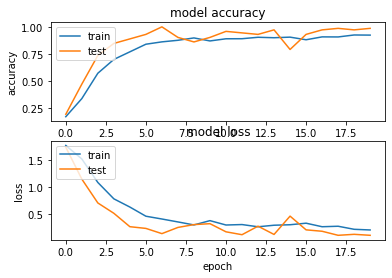

In [10]:
import matplotlib.pyplot as plt 
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()


# Evaluation of trained model

In [11]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test accuracy:", test_accuracy)


Found 72 images belonging to 6 classes.
3/3 [==============================] - 0s 103ms/step - loss: 0.0719 - accuracy: 0.9722
Test accuracy: 0.9722222089767456


## Classification report

In [12]:
from sklearn.metrics import classification_report


In [13]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Assuming you've trained and saved your model as 'model'
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
true_classes = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # List of class labels


Found 72 images belonging to 6 classes.


In [14]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels,zero_division=1)
print(report)


              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       0.92      1.00      0.96        12
     Patches       1.00      1.00      1.00        12
      Pitted       1.00      0.83      0.91        12
      Rolled       0.92      1.00      0.96        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           0.97        72
   macro avg       0.97      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72

